In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("/glade/u/home/lverhoef/gdl-storm-mode/notebooks"))
from imports.GDL_layers import *
import shap

/glade/u/home/lverhoef/.conda/envs/shap-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
train_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_train_data.nc")
validation_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_validation_data.nc")
test_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_test_data.nc")

In [3]:
X_train = train_ds['ellipse'].expand_dims(dim='channel', axis=-1)
X_train['p'] = np.arange(X_train['p'].shape[0])
Y_train = train_ds[['maj_len', 'min_len']].to_array().transpose()
Y_train['p'] = np.arange(Y_train['p'].shape[0])
X_val = validation_ds['ellipse'].expand_dims(dim='channel', axis=-1)
X_val['p'] = np.arange(X_val['p'].shape[0])
Y_val = validation_ds[['maj_len', 'min_len']].to_array().transpose()
Y_val['p'] = np.arange(Y_val['p'].shape[0])
X_test = test_ds['ellipse'].expand_dims(dim='channel', axis=-1)
X_test['p'] = np.arange(X_test['p'].shape[0])
Y_test = test_ds[['maj_len', 'min_len']].to_array().transpose()
Y_test['p'] = np.arange(Y_test['p'].shape[0])

In [4]:
# Normalize the output data
Y_scale_stats = pd.DataFrame(index=range(Y_train.shape[-1]), columns=["mean", "sd"])
Y_scale_stats.loc[:, "mean"] = Y_train.mean(dim="p")
Y_scale_stats.loc[:, "sd"] = Y_train.std(dim="p")
Y_train_norm = xr.DataArray(coords=Y_train.coords, dims=Y_train.dims)
Y_val_norm = xr.DataArray(coords=Y_val.coords, dims=Y_val.dims)
Y_test_norm = xr.DataArray(coords=Y_test.coords, dims=Y_test.dims)
for i in range(Y_train.shape[-1]):
    Y_train_norm[:, i] = (Y_train[:, i] - Y_scale_stats.loc[i, "mean"]) / Y_scale_stats.loc[i, "sd"]
    Y_val_norm[:, i] = (Y_val[:, i] - Y_scale_stats.loc[i, "mean"]) / Y_scale_stats.loc[i, "sd"]
    Y_test_norm[:, i] = (Y_test[:, i] - Y_scale_stats.loc[i, "mean"]) / Y_scale_stats.loc[i, "sd"]

In [5]:
model = models.Sequential()
model.add(RotEquivConv2D(32, (3, 3), rot_axis=False, input_shape=(128, 128, 1)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(32, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(64, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(64, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(128, (3, 3)))
model.add(layers.MaxPool3D((1, 1, 4)))
# model.add(RotInvPool())
model.add(layers.Flatten())
model.add(layers.Dense(32))
model.add(layers.Dense(2))

2022-08-10 13:19:00.930598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 13:19:01.622684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [6]:
model.compile(
    optimizer='adam',
    loss='mse',
)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d (RotEquivC  (None, 126, 126, 4, 32)  320       
 onv2D)                                                          
                                                                 
 rot_equiv_pool2d (RotEquivP  (None, 63, 63, 4, 32)    0         
 ool2D)                                                          
                                                                 
 rot_equiv_conv2d_1 (RotEqui  (None, 61, 61, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_1 (RotEqui  (None, 30, 30, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_2 (RotEqui  (None, 28, 28, 4, 64)    1

In [8]:
history = model.fit(
    x=X_train, y=Y_train_norm,
    epochs=10, validation_data=(X_val, Y_val_norm),
    shuffle=True
)

Epoch 1/10


2022-08-10 12:04:23.545026: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


313/313 [==============================] - 25s 59ms/step - loss: 0.3417 - val_loss: 0.1075
Epoch 2/10
313/313 [==============================] - 18s 56ms/step - loss: 0.0523 - val_loss: 0.0305
Epoch 3/10
313/313 [==============================] - 18s 56ms/step - loss: 0.0199 - val_loss: 0.0163
Epoch 4/10
313/313 [==============================] - 18s 57ms/step - loss: 0.0160 - val_loss: 0.0127
Epoch 5/10
313/313 [==============================] - 18s 57ms/step - loss: 0.0154 - val_loss: 0.0125
Epoch 6/10
313/313 [==============================] - 18s 56ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 7/10
313/313 [==============================] - 18s 56ms/step - loss: 0.0109 - val_loss: 0.0115
Epoch 8/10
313/313 [==============================] - 18s 57ms/step - loss: 0.0112 - val_loss: 0.0159
Epoch 9/10
313/313 [==============================] - 18s 56ms/step - loss: 0.0082 - val_loss: 0.0088
Epoch 10/10
313/313 [==============================] - 18s 56ms/step - loss: 0.0098 - val_los

<xarray.Dataset>
Dimensions:  (p: 10)
Dimensions without coordinates: p
Data variables:
    maj_len  (p) float64 26.64 12.29 21.85 22.32 25.26 ... 21.0 36.23 38.3 28.21
    min_len  (p) float64 17.37 7.178 14.07 1.839 ... 12.29 16.74 17.86 8.65

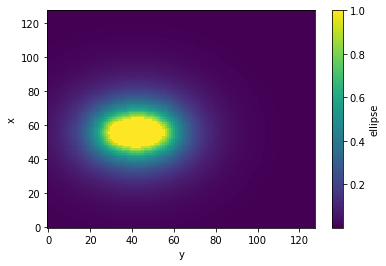

In [9]:
validation_ds['ellipse'][0, :, :].plot()
validation_ds[['maj_len', 'min_len']].sel(p=slice(0, 10))

In [10]:
model.predict(X_val[0:10, :, :, :])

1/1 [==============================] - 1s 502ms/step


array([[ 0.29341567,  1.392396  ],
       [-1.5094942 , -0.3405594 ],
       [-0.3645325 ,  0.75144064],
       [-0.36668283, -1.2113566 ],
       [-0.0041914 , -0.31313783],
       [ 1.4809726 ,  1.8196793 ],
       [-0.48120016,  0.5722766 ],
       [ 1.3243164 ,  1.313186  ],
       [ 1.5115491 ,  1.4420338 ],
       [ 0.3356798 , -0.10453843]], dtype=float32)

In [11]:
CNN_model = models.Sequential()
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dense(32, activation='relu'))
CNN_model.add(layers.Dense(2))

In [12]:
CNN_model.compile(
    optimizer='adam',
    loss='mse',
)

In [13]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)      

In [14]:
CNN_history = CNN_model.fit(
    x=X_train, y=Y_train_norm,
    epochs=10, validation_data=(X_val, Y_val_norm),
    shuffle=True
)

Epoch 1/10
313/313 [==============================] - 4s 13ms/step - loss: 0.3948 - val_loss: 0.2026
Epoch 2/10
313/313 [==============================] - 4s 13ms/step - loss: 0.1349 - val_loss: 0.0624
Epoch 3/10
313/313 [==============================] - 4s 14ms/step - loss: 0.0615 - val_loss: 0.0750
Epoch 4/10
313/313 [==============================] - 5s 16ms/step - loss: 0.0404 - val_loss: 0.0289
Epoch 5/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0272 - val_loss: 0.0290
Epoch 6/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0203 - val_loss: 0.0178
Epoch 7/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0194 - val_loss: 0.0132
Epoch 8/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0165 - val_loss: 0.0232
Epoch 9/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0163 - val_loss: 0.0208
Epoch 10/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0143 - val_lo

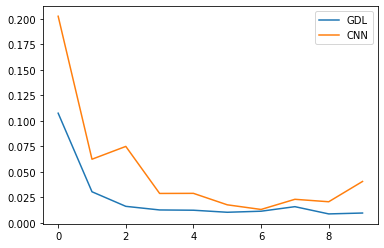

In [19]:
a = plt.plot(history.history['val_loss'], label='GDL')
b = plt.plot(CNN_history.history['val_loss'], label='CNN')
plt.legend()

In [33]:
model.save("saved_models/toy_ds_ricnn_shap/ricnn_model")
CNN_model.save("saved_models/toy_ds_ricnn_shap/cnn_model")

INFO:tensorflow:Assets written to: saved_models/toy_ds_ricnn_shap/ricnn_model/assets


INFO:tensorflow:Assets written to: saved_models/toy_ds_ricnn_shap/cnn_model/assets


INFO:tensorflow:Assets written to: saved_models/toy_ds_ricnn_shap/cnn_model/assets


In [10]:
model = tf.keras.models.load_model("saved_models/toy_ds_ricnn_shap/ricnn_model")
CNN_model = tf.keras.models.load_model("saved_models/toy_ds_ricnn_shap/cnn_model")

In [11]:
model.evaluate(X_val, Y_val_norm)
model.evaluate(X_test, Y_test_norm)

2022-08-10 13:19:36.966716: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


32/32 [==============================] - 1s 21ms/step - loss: 0.0114


0.011370174586772919

In [12]:
CNN_model.evaluate(X_val, Y_val_norm)
CNN_model.evaluate(X_test, Y_test_norm)

32/32 [==============================] - 0s 12ms/step - loss: 0.7904


0.7903503775596619

In [13]:
rand = np.random.default_rng()
background = rand.choice(X_train, size=100, replace=False)

In [28]:
maj_model = tf.keras.Model(model.inputs, model.outputs[0][:, 0])
maj_CNN_model = tf.keras.Model(CNN_model.inputs, CNN_model.outputs[0][:, 0])

In [22]:
CNN_exp = shap.GradientExplainer(CNN_model, background)
exp = shap.GradientExplainer(model, background)

In [93]:
masker_blur = shap.maskers.Image("blur(2,2)", X_train[0].shape)
exp = shap.Explainer(model, masker_blur, output_names=["major axis", "minor axis"])
CNN_exp = shap.Explainer(CNN_model, masker_blur, output_names=["major axis", "minor axis"])

In [94]:
shap_val = exp(X_test[0:5].values, max_evals=500)
CNN_shap_val = CNN_exp(X_test[0:5].values, max_evals=500)

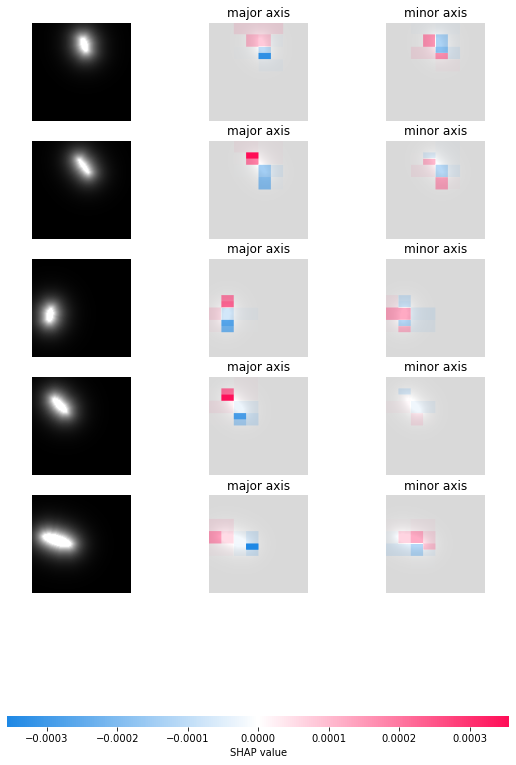

In [95]:
shap.image_plot(shap_val, X_test[0:5].values, labels=np.array(['major axis', 'minor axis']*5).reshape(-1, 2))

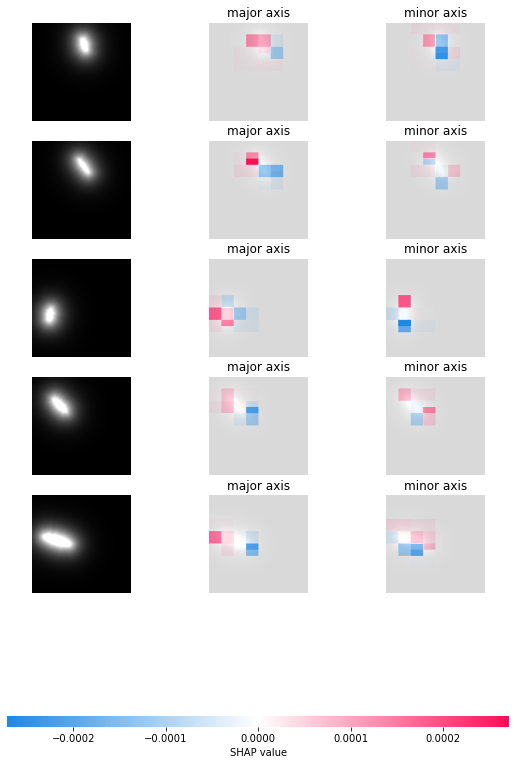

In [96]:
shap.image_plot(CNN_shap_val, X_test[0:5].values, labels=np.array(['major axis', 'minor axis']*5).reshape(-1, 2))

In [84]:
np.array(['major axis', 'minor axis']*5).reshape(-1, 2)

array([['major axis', 'minor axis'],
       ['major axis', 'minor axis'],
       ['major axis', 'minor axis'],
       ['major axis', 'minor axis'],
       ['major axis', 'minor axis']], dtype='<U10')